In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import math
import matplotlib.pyplot as plt 
import os 
from sklearn.linear_model import LinearRegression
from statistics import mean
from sklearn import preprocessing as prep


In [2]:
train = pd.read_csv("traindata.csv")
test = pd.read_csv("testdata.csv")
submit = pd.read_csv("sample_submission.csv")


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


In [4]:
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


Training set has <b>1549</b> enteries<br>
It has <b>176</b> unique 

In [5]:
submit['Patient'] = submit['Patient_Week'].apply(lambda x :x.split('_')[0])
submit['Weeks'] = submit['Patient_Week'].apply(lambda x :x.split('_')[-1])

submit = submit.drop('FVC', axis=1)
submit = submit[['Patient', 'Weeks', 'Confidence', 'Patient_Week']]
submit = submit.merge(test.drop('Weeks',axis=1), on='Patient')  

#730 is the 5 records for 146 patients

In [6]:
submit = submit[['Patient', 'Weeks','FVC','Percent', 'Age', 'Sex','SmokingStatus' ,'Confidence', 'Patient_Week']] #Reordering


In [7]:
#Adding indicator for dataset identification

train["Dataset"] = 'Train'
test["Dataset"] = 'Test'
submit["Dataset"] = 'Submission'

In [8]:
train.iloc[train.duplicated(['Patient', 'Weeks'], keep=False).sort_values(ascending=False).head(14).index].sort_values(by=['Patient'])

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Dataset
167,ID00048637202185016727717,9,1477,64.514720,70,Female,Never smoked,Train
166,ID00048637202185016727717,9,1375,60.059404,70,Female,Never smoked,Train
227,ID00068637202190879923934,11,2827,83.609369,73,Male,Ex-smoker,Train
226,ID00068637202190879923934,11,2794,82.633385,73,Male,Ex-smoker,Train
306,ID00089637202204675567570,7,2478,57.967624,63,Male,Never smoked,Train
307,ID00089637202204675567570,7,2539,59.394592,63,Male,Never smoked,Train
465,ID00125637202218590429387,8,2349,53.757781,65,Male,Never smoked,Train
466,ID00125637202218590429387,8,2584,59.135848,65,Male,Never smoked,Train
750,ID00199637202248141386743,5,2672,64.728682,62,Male,Ex-smoker,Train
751,ID00199637202248141386743,5,2683,64.995155,62,Male,Ex-smoker,Train


After checking dataset for duplicates it was found that there are seven patients who recorded more than one(here two) FVC readings for the same week. To establish consistency the average of readings was taken and then added back to the database for both <b>FVC</b> and <b>Percent</b>.

In [9]:
temp = train.groupby(['Patient', 'Weeks'], as_index=False)['FVC','Percent'].mean()

train = train.drop_duplicates(['Patient','Weeks']).drop(['FVC','Percent'],axis=1).merge(temp, on=['Patient', 'Weeks'])
len(train['Patient'].unique())

176

In [10]:
train.describe()

,Weeks,Age,FVC,Percent
count,1542.000000,1542.000000,1542.000000,1542.000000
mean,31.931907,67.192607,2691.263294,77.710239
std,23.229854,7.068397,833.927148,19.847108
min,-5.000000,49.000000,827.000000,28.877577
25%,12.000000,63.000000,2108.250000,62.840249
50%,28.000000,68.000000,2642.000000,75.677774
75%,47.000000,72.000000,3175.000000,88.650583
max,133.000000,88.000000,6399.000000,153.145378


## Merging training and testing data to keep modification to dataset consistent
<br>To make sure we apply any dataset modification to both the training and testing data we will concantenate the two dataframes and work with the merged new dataset 
<br>The dataset can be then grouped by <i>'Dataset'</i> column or using slicing. <b>1542</b> records belong to training data and <b>5</b> to testing.

In [11]:
data = pd.concat([train, test], ignore_index = True )

In [12]:
 data['Required'] = (data['FVC'] / (data['Percent'] / 100)).round(decimals = 2)


In [13]:
def estimate_height(row, sex):
    return ((row.Required /1000)  + 0.026 * row.Age + 2.89) / 0.0443


data['Height'] = data.apply(lambda x : estimate_height(x, x.Sex),axis=1)

In [14]:
data.drop_duplicates(['Patient']).head()

,Patient,Weeks,Age,Sex,SmokingStatus,Dataset,FVC,Percent,Required,Height
0,ID00007637202177411956430,-4,79,Male,Ex-smoker,Train,2315.0,58.253649,3974.0,201.309255
9,ID00009637202177434476278,8,69,Male,Ex-smoker,Train,3660.0,85.282878,4291.6,202.609481
18,ID00010637202177584971671,0,60,Male,Ex-smoker,Train,3523.0,94.724672,3719.2,184.406321
27,ID00011637202177653955184,6,72,Male,Ex-smoker,Train,3326.0,85.987590,3868.0,194.808126
36,ID00012637202177665765362,33,65,Male,Never smoked,Train,3418.0,93.726006,3646.8,185.706546


## Encoding Training & Testing Data
### Categorical encoding the Smoking Status
Smoking Status is labelled as follows:<br>
2  <-- Currently Smoking <br>
1  <-- Ex-Smoker <br>
0  <-- Never Smoked  <br>

Sex is label encoded and then one hot encoded. <br>
1 = Male  0 = Female


In [15]:
data['SmokingStatus'].unique()

array(['Ex-smoker', 'Never smoked', 'Currently smokes'], dtype=object)

In [16]:

smoking_status_dict ={'Never smoked':0, 'Ex-smoker':1, 'Currently smokes': 2}
data['SmokingStatus'] = data['SmokingStatus'].map(smoking_status_dict)


In [17]:
data.drop_duplicates('Patient').head()

,Patient,Weeks,Age,Sex,SmokingStatus,Dataset,FVC,Percent,Required,Height
0,ID00007637202177411956430,-4,79,Male,1,Train,2315.0,58.253649,3974.0,201.309255
9,ID00009637202177434476278,8,69,Male,1,Train,3660.0,85.282878,4291.6,202.609481
18,ID00010637202177584971671,0,60,Male,1,Train,3523.0,94.724672,3719.2,184.406321
27,ID00011637202177653955184,6,72,Male,1,Train,3326.0,85.987590,3868.0,194.808126
36,ID00012637202177665765362,33,65,Male,0,Train,3418.0,93.726006,3646.8,185.706546


In [18]:
onehot_sex = pd.get_dummies(data['Sex'], prefix="Sex_") #Get dummies takes a series input and outputs a dataframe outputs a dataframe

data = data.join(onehot_sex)
data = data.drop('Sex', axis=1)



In [19]:
data

,Patient,Weeks,Age,SmokingStatus,Dataset,FVC,Percent,Required,Height,Sex__Female,Sex__Male
0,ID00007637202177411956430,-4,79,1,Train,2315.0,58.253649,3974.0,201.309255,0,1
1,ID00007637202177411956430,5,79,1,Train,2214.0,55.712129,3974.0,201.309255,0,1
2,ID00007637202177411956430,7,79,1,Train,2061.0,51.862104,3974.0,201.309255,0,1
3,ID00007637202177411956430,9,79,1,Train,2144.0,53.950679,3974.0,201.309255,0,1
4,ID00007637202177411956430,11,79,1,Train,2069.0,52.063412,3974.0,201.309255,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1542,ID00419637202311204720264,6,73,1,Test,3020.0,70.186855,4302.8,205.209932,0,1
1543,ID00421637202311550012437,15,68,1,Test,2739.0,82.045291,3338.4,180.505643,0,1
1544,ID00422637202311677017371,6,73,1,Test,1930.0,76.672493,2517.2,164.902935,0,1
1545,ID00423637202312137826377,17,72,1,Test,3294.0,79.258903,4156.0,201.309255,0,1


In [20]:
#Checking for null enteries in database
data[data.isnull().any(axis=1)].head()

,Patient,Weeks,Age,SmokingStatus,Dataset,FVC,Percent,Required,Height,Sex__Female,Sex__Male


## Correlation Matrix
Identify the relationship of features in the data set using correlation matrix <br>
<b>1. Correlation without rate of decline feature</b> 

In [21]:
#Minimized data set containing only the first reading of the scan with all other features
data_min = data.groupby(['Patient']).first()
data_min.rename(columns={'Weeks': 'First_Week', 'FVC': 'First_FVC'}, inplace=True)
data_min.reset_index()

,Patient,First_Week,Age,SmokingStatus,Dataset,First_FVC,Percent,Required,Height,Sex__Female,Sex__Male
0,ID00007637202177411956430,-4,79,1,Train,2315.0,58.253649,3974.0,201.309255,0,1
1,ID00009637202177434476278,8,69,1,Train,3660.0,85.282878,4291.6,202.609481,0,1
2,ID00010637202177584971671,0,60,1,Train,3523.0,94.724672,3719.2,184.406321,0,1
3,ID00011637202177653955184,6,72,1,Train,3326.0,85.987590,3868.0,194.808126,0,1
4,ID00012637202177665765362,33,65,0,Train,3418.0,93.726006,3646.8,185.706546,0,1
...,...,...,...,...,...,...,...,...,...,...,...
171,ID00419637202311204720264,6,73,1,Train,3020.0,70.186855,4302.8,205.209932,0,1
172,ID00421637202311550012437,15,68,1,Train,2739.0,82.045291,3338.4,180.505643,0,1
173,ID00422637202311677017371,6,73,1,Train,1930.0,76.672493,2517.2,164.902935,0,1
174,ID00423637202312137826377,17,72,1,Train,3294.0,79.258903,4156.0,201.309255,0,1


In [23]:

def best_fit_slope(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)**2) - mean(xs**2)))

    b = mean(ys) - (m * mean(xs))
    return (m , b)

rod = []
error = []
for id, d in data.drop_duplicates(['Patient', 'Weeks']).groupby('Patient'):
        m, b = best_fit_slope(d.Weeks, d.FVC)
        rod.append(m)
        error.append(b)

data_min['ROD'] = rod

data_reg = data_min.copy()
data_reg['Intercept'] = error

data_reg.reset_index(inplace=True)


<AxesSubplot:>

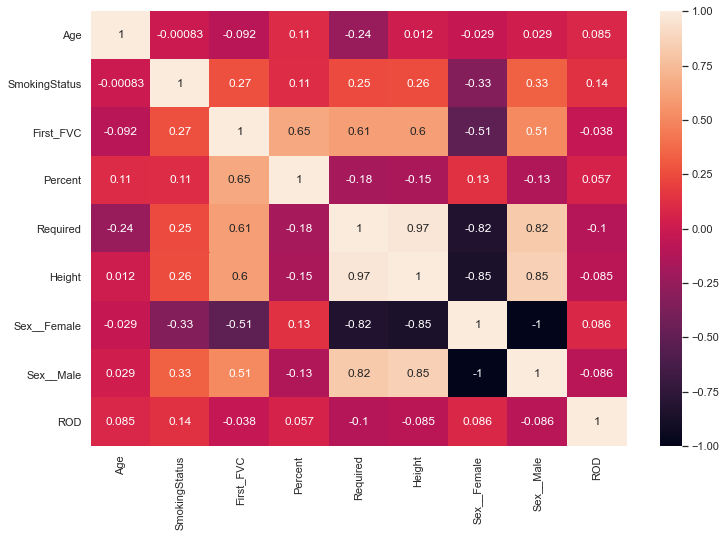

In [27]:
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(data_min.drop(['Dataset', 'First_Week'],axis=1).corr(), annot =True, cmap="rocket")

<AxesSubplot:xlabel='First_FVC', ylabel='Density'>

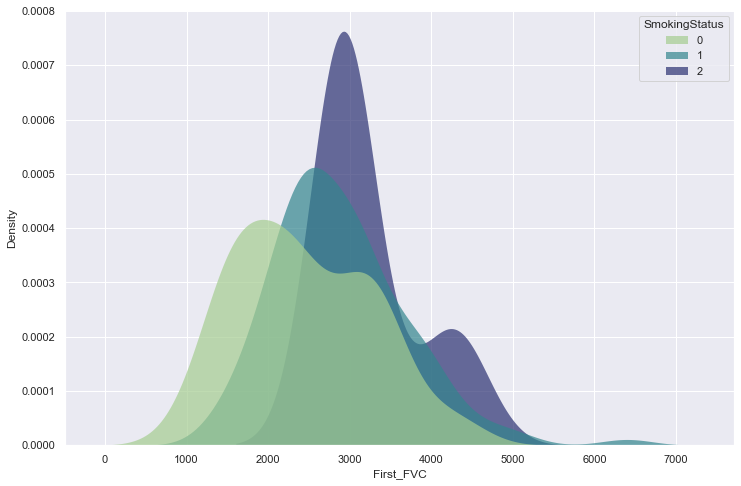

In [24]:
sns.kdeplot(data=data_min, x='First_FVC',linewidth = 0, palette = "crest", alpha = .7, common_norm = False , fill=True, hue='SmokingStatus')

### Histogram to denote the density of available records per patient

<AxesSubplot:xlabel='Weeks', ylabel='Density'>

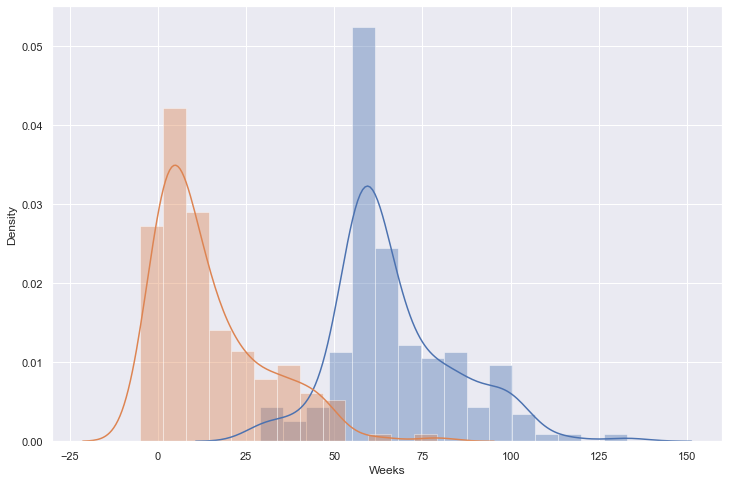

In [25]:
sns.set(rc={'figure.figsize':(12,8)})
sns.distplot(data[:1543].groupby('Patient')['Weeks'].max())  
sns.distplot(data[:1543].groupby('Patient')['Weeks'].min())  

### Identifying the average deviation of first FVC reading from the date of scan

[[]]

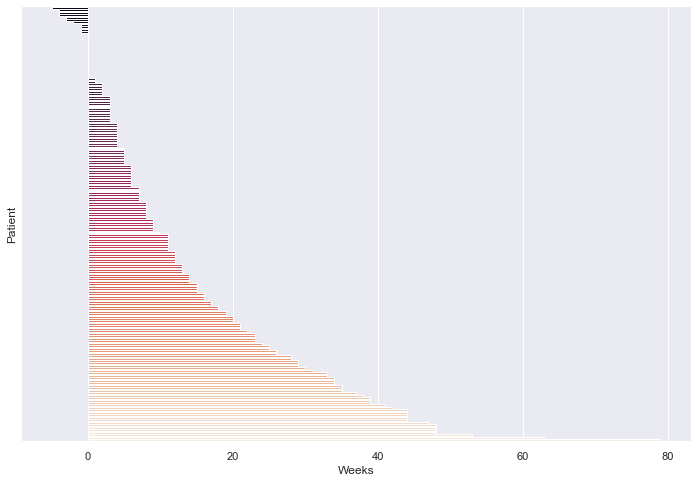

In [26]:
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(x='Weeks',y='Patient', data=train[:1543].drop_duplicates(['Patient']).sort_values('Weeks'), palette="rocket")
ax.set(yticks= [])


In [32]:
data_min.describe()

,First_Week,Age,SmokingStatus,First_FVC,Percent,Required,Height,Sex__Female,Sex__Male,ROD
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,14.363636,67.261364,0.772727,2773.400568,80.218926,3488.660227,183.464011,0.210227,0.789773,-4.513627
std,15.302050,7.088009,0.528659,834.866224,19.384324,744.540458,16.334692,0.408632,0.408632,6.124729
min,-5.000000,49.000000,0.000000,1015.000000,43.352279,1598.900000,143.000000,0.000000,0.000000,-28.182575
25%,3.000000,63.000000,0.000000,2229.000000,66.187948,3118.700000,176.279910,0.000000,1.000000,-7.588524
50%,9.000000,68.000000,1.000000,2667.750000,78.919584,3657.000000,187.720090,0.000000,1.000000,-3.843893
75%,22.250000,72.000000,1.000000,3239.250000,90.997135,4008.600000,194.808126,0.000000,1.000000,-0.950083
max,79.000000,88.000000,2.000000,6399.000000,153.012912,4923.200000,213.011287,1.000000,1.000000,14.682612
